In [2]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

In [1]:

import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

In [5]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [ ]:

for cl in classes:
    
    img_path = os.path.join(base_dir, cl)
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} Images".format(cl, len(images)))
    num_train = int(round(len(images)*0.8))
    train, val = images[:num_train], images[num_train:]

    for t in train:
        try:
            if not os.path.exists(os.path.join(base_dir, 'train', cl)):
                os.makedirs(os.path.join(base_dir, 'train', cl))
            shutil.move(t, os.path.join(base_dir, 'train', cl))
        except Exception as e:
            print(e)
            pass
    for v in val:
        try:
            if not os.path.exists(os.path.join(base_dir, 'val', cl)):
                os.makedirs(os.path.join(base_dir, 'val', cl))
            shutil.move(v, os.path.join(base_dir, 'val', cl))
        except Exception as e:
            print(e)
            pass

In [11]:
batch_size = 100
IMG_SHAPE = 150 

In [47]:
        image_gen = ImageDataGenerator(**PARAMS)

        data_gen = image_gen.flow_from_directory(
                                                    batch_size=batch_size,
                                                    directory=base_dir,
                                                    shuffle=True,
                                                    target_size=(IMG_SHAPE,IMG_SHAPE), class_mode='sparse'
                                                    )
        
        class_lkup = {v:k for k,v in data_gen.class_indices.items()}

Found 7340 images belonging to 7 classes.


In [48]:
batch, class_idx = data_gen.next()

In [51]:
base_dir

'C:\\Users\\rohan\\.keras\\datasets\\flower_photos'

In [12]:
import utils
import importlib
importlib.reload(utils)

IC = utils.ImageCollector(classes)
for img_fpath, cl in IC.collect_anchor_images(base_dir, ext='.jpg'):
    IC.move_anchor_images(img_fpath, copy_dir='actual', cl=cl, IMG_SHAPE=IMG_SHAPE,IS_BGR=False)

In [13]:
PARAMS = dict(rotation_range=1,
                width_shift_range=.05,
                height_shift_range=.05)

In [14]:
IC.create_transformed_images(base_dir='actual', copy_dir='transformed', PARAMS=PARAMS, IMG_SHAPE=IMG_SHAPE,
                             batch_size=batch_size, IS_BGR=False)

Found 3670 images belonging to 5 classes.


In [15]:
img_idx_to_base_idxs = IC.img_idx_to_base_idxs

In [19]:
import training
import importlib
importlib.reload(training)

<module 'training' from 'C:\\Users\\rohan\\deep-learning-train\\image-hashing-network\\training.py'>

In [20]:
model = training.ImageMatcher(IMG_SHAPE=IMG_SHAPE, img_idx_to_base_idxs=img_idx_to_base_idxs)

In [21]:
for _ in range(600*1):
    model.train_step()

loss:  -0.0008340468
loss:  -0.001015429
loss:  -5.438104e-05
loss:  -0.00049036724
loss:  -0.00074187823
loss:  -0.00093947555
loss:  -0.00072671747
loss:  -0.00144428
loss:  -0.0007418402
loss:  -0.0013948849
loss:  -0.0016805514
loss:  -0.0007211521
loss:  -0.0011888726
loss:  -0.0010743622
loss:  -0.0008734354
loss:  -0.0022986843
loss:  -0.0012547524
loss:  -0.0020335144
loss:  -0.0021718203
loss:  -0.0009994922
loss:  -0.0010401891
loss:  -0.00035671354
loss:  -0.0012377851
loss:  -0.002011025
loss:  -0.0012364441
loss:  -0.0028279491
loss:  -0.0009079919
loss:  -0.0016590462
loss:  -0.0012035748
loss:  -0.0023946348
loss:  -0.0011268253
loss:  -0.002603185
loss:  -0.0007264585
loss:  -0.002035144
loss:  -0.0045514423
loss:  -0.0024091974
loss:  -0.0017954463
loss:  -0.0019122236
loss:  -0.0022136993
loss:  -0.0021805994
loss:  -0.003289116
loss:  -0.0034372166
loss:  -0.0019960713
loss:  -0.0039668204
loss:  -0.0026345057
loss:  -0.0047350433
loss:  -0.004326445
loss:  -0.003827

In [23]:
import cv2
def hash_indentifier(im_arr,plot=False):
    im_arr = im_arr/(tf.reduce_sum(im_arr))
    rounded = im_arr.numpy().flatten()
    return ' '.join(list(map(str,rounded)))

import pandas as pd
df = pd.DataFrame(columns=['filename','hash'])


count=0 
for cl in classes:
    img_path = os.path.join('actual', cl)
    images = glob.glob(img_path + '/*.png')

    for t in images:
        img = cv2.imread(t)

        hashed = hash_indentifier(model.model.layers[-1](tf.cast(tf.expand_dims(img,0),tf.float32)))

        df.loc[count,['filename','hash']] = [t, hashed]
        count+=1

In [26]:
def seq_matcher(x,y):
    x = np.array(x.split(' ')).astype(float)
    y = np.array(y.split(' ')).astype(float)

    return np.sum((x-y)**2)

image_gen = ImageDataGenerator(
                    rotation_range=5,
                    width_shift_range=.05,
                    height_shift_range=.05)

valid_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory='actual',
                                                shuffle=False,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),class_mode='sparse'
                                                )

tot=0
matched=0
plot_matches=False
sample_size = 10
for _ in range(valid_data_gen.n//batch_size):
    batch,class_idx = valid_data_gen.next()
    
    idx_left = (valid_data_gen.batch_index - 1) * batch_size
    idx_right = idx_left + valid_data_gen.batch_size if idx_left >= 0 else None
    indices = valid_data_gen.index_array[idx_left:idx_right]
    actual_file_names = ['actual\\'+valid_data_gen.filenames[i] for i in indices]
    
#     print(actual_file_names)
    N = batch.shape[0]
    for i in range(N)[:sample_size]:
        img = batch[i]
        
    
        img = cv2.resize(img,(IMG_SHAPE,IMG_SHAPE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        hashed = hash_indentifier(model.embeddings(tf.cast(tf.expand_dims(img,0),tf.float32)))
        
        err  = df.copy()

        err['error'] = err['hash'].apply(lambda x: seq_matcher(x,hashed))
        if plot_matches==True:
            plt.figure(figsize=(20,10))
            v = 0
        for matched_file,error in err.sort_values(by='error')[:1][['filename','error']].values[::-1]:
            if matched_file==actual_file_names[i]:
                matched+=1

            if plot_matches==True:
                plt.subplot(1,6,1+v)
                matched_img = cv2.imread(matched_file)
                plt.imshow(matched_img/255)

                import time
                time.sleep(0.1)
                v+=1

                if v>0:

                    plt.subplot(1,6,1+v)
                    plt.imshow(img/255)
                    plt.show()
        if plot_matches==True:
            plt.close()
        tot+=1
        print('accuracy:', matched/tot,'N correct matches:',matched)

Found 3670 images belonging to 5 classes.
accuracy: 1.0 N correct matches: 1
accuracy: 1.0 N correct matches: 2
accuracy: 1.0 N correct matches: 3
accuracy: 1.0 N correct matches: 4
accuracy: 1.0 N correct matches: 5
accuracy: 0.8333333333333334 N correct matches: 5
accuracy: 0.8571428571428571 N correct matches: 6
accuracy: 0.875 N correct matches: 7
accuracy: 0.8888888888888888 N correct matches: 8
accuracy: 0.9 N correct matches: 9
accuracy: 0.9090909090909091 N correct matches: 10
accuracy: 0.9166666666666666 N correct matches: 11
accuracy: 0.9230769230769231 N correct matches: 12
accuracy: 0.9285714285714286 N correct matches: 13
accuracy: 0.9333333333333333 N correct matches: 14
accuracy: 0.9375 N correct matches: 15
accuracy: 0.9411764705882353 N correct matches: 16
accuracy: 0.9444444444444444 N correct matches: 17
accuracy: 0.9473684210526315 N correct matches: 18
accuracy: 0.95 N correct matches: 19
accuracy: 0.9523809523809523 N correct matches: 20
accuracy: 0.95454545454545

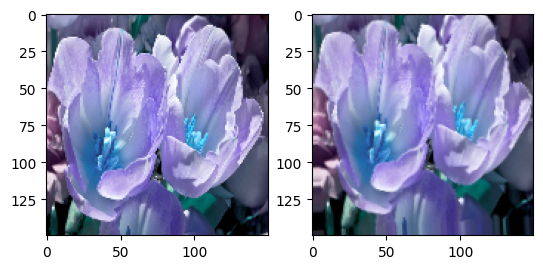

In [28]:
v = 0
plt.figure(figsize=(20,10))
for matched_file,error in err.sort_values(by='error')[:1][['filename','error']].values[::-1]:
    plt.subplot(1,6,1+v)
    matched_img = cv2.imread(matched_file)
    plt.imshow(matched_img/255)
    
    import time
    time.sleep(0.1)
    v+=1
    
    if v>0:
    
        plt.subplot(1,6,1+v)
        plt.imshow(img/255)
        plt.show()

# Validation on Horses and Humans Dataset

Horses or humans dataset: https://laurencemoroney.com/datasets.html#google_vignette

In [33]:
# Load the dataset
# import tensorflow_datasets as tfds
# dataset_name = 'horses_or_humans'
# dataset, info = tfds.load(dataset_name, with_info=True, as_supervised=False)

In [34]:
# Add to the flowers dataset
count = df.index.max()
        
for cl in ['horses','humans']:
    img_path = os.path.join('horse-or-human', cl)
    images = glob.glob(img_path + '/*.png')

    for t in images:
        img = cv2.imread(t)
        img = cv2.resize(img,(IMG_SHAPE,IMG_SHAPE))

        hashed = hash_indentifier(model.embeddings(tf.cast(tf.expand_dims(img,0),tf.float32)))
        df.loc[count,['filename','hash']] = [t,hashed]
        count+=1

In [36]:
def seq_matcher(x,y):
    x = np.array(x.split(' ')).astype(float)
    y = np.array(y.split(' ')).astype(float)


    return np.sum((x-y)**2)


image_gen = ImageDataGenerator(
                    rotation_range=5,
                    width_shift_range=.05,
                    height_shift_range=.05)

valid_data_gen = image_gen.flow_from_directory(
                                                batch_size=batch_size,
                                                directory='horse-or-human',
                                                shuffle=False,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),class_mode='sparse'
                                                )
tot=0
matched=0
plot_matches=False
sample_size = 10
for _ in range(valid_data_gen.n//batch_size):
    batch,class_idx = valid_data_gen.next()
    
    idx_left = (valid_data_gen.batch_index - 1) * batch_size
    idx_right = idx_left + valid_data_gen.batch_size if idx_left >= 0 else None
    indices = valid_data_gen.index_array[idx_left:idx_right]
    actual_file_names = ['horse-or-human\\'+valid_data_gen.filenames[i] for i in indices]
    

    N = batch.shape[0]
    for i in range(N)[:sample_size]:
        img = batch[i]
        
    
        img = cv2.resize(img,(IMG_SHAPE,IMG_SHAPE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        hashed = hash_indentifier(model.embeddings(tf.cast(tf.expand_dims(img,0),tf.float32)))
        
        err  = df.copy()
        

        err['error'] = err['hash'].apply(lambda x: seq_matcher(x,hashed))
        if plot_matches==True:
            plt.figure(figsize=(20,10))
            v = 0
        for matched_file,error in err.sort_values(by='error')[:1][['filename','error']].values[::-1]:
            if matched_file==actual_file_names[i]:
                matched+=1

            if plot_matches==True:
                plt.subplot(1,6,1+v)
                matched_img = cv2.imread(matched_file)
                plt.imshow(matched_img/255)

                import time
                time.sleep(0.1)
                v+=1

                if v>0:

                    plt.subplot(1,6,1+v)
                    plt.imshow(img/255)
                    plt.show()
        if plot_matches==True:
            plt.close()
        tot+=1
        print('accuracy:', matched/tot,'N correct matches:',matched)

Found 1027 images belonging to 2 classes.
accuracy: 1.0 N correct matches: 1
accuracy: 1.0 N correct matches: 2
accuracy: 1.0 N correct matches: 3
accuracy: 1.0 N correct matches: 4
accuracy: 1.0 N correct matches: 5
accuracy: 1.0 N correct matches: 6
accuracy: 1.0 N correct matches: 7
accuracy: 1.0 N correct matches: 8
accuracy: 1.0 N correct matches: 9
accuracy: 1.0 N correct matches: 10
accuracy: 1.0 N correct matches: 11
accuracy: 1.0 N correct matches: 12
accuracy: 1.0 N correct matches: 13
accuracy: 1.0 N correct matches: 14
accuracy: 0.9333333333333333 N correct matches: 14
accuracy: 0.9375 N correct matches: 15
accuracy: 0.9411764705882353 N correct matches: 16
accuracy: 0.9444444444444444 N correct matches: 17
accuracy: 0.9473684210526315 N correct matches: 18
accuracy: 0.95 N correct matches: 19
accuracy: 0.9523809523809523 N correct matches: 20
accuracy: 0.9545454545454546 N correct matches: 21
accuracy: 0.9130434782608695 N correct matches: 21
accuracy: 0.9166666666666666 N

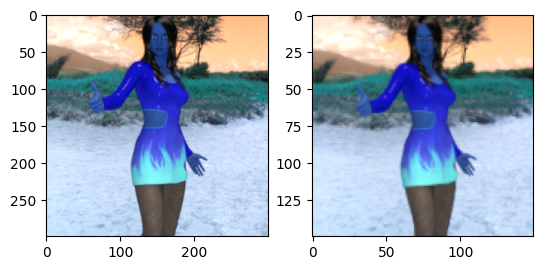

In [38]:
plt.figure(figsize=(20,10))
v = 0
for matched_file,error in err.sort_values(by='error')[:1][['filename','error']].values[::-1]:
    plt.subplot(1,6,1+v)
    matched_img = cv2.imread(matched_file)
    plt.imshow(matched_img/255)
    
    import time
    time.sleep(0.1)
    v+=1
    
    if v>0:
    
        plt.subplot(1,6,1+v)
        plt.imshow(img/255)
        plt.show()